In [1]:
# get data
import numpy as np
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

In [2]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [3]:
# Open trajectories

from msmbuilder.dataset import dataset
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X)

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length set([500.0]) ns


In [4]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(1000L, 264L, 3L)
(1000L, 84L)


In [5]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000L, 84L)
(1000L, 4L)


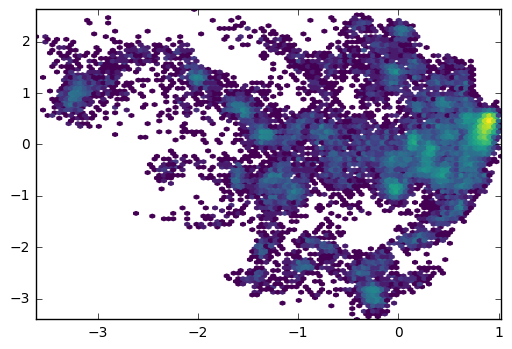

In [6]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [7]:
#clustering

from msmbuilder.cluster import MiniBatchKMeans

num_cluster = 97
clusterer = MiniBatchKMeans(n_clusters=num_cluster, max_no_improvement=1000)
clustered_trajs = tica_trajs.fit_transform_with(clusterer, 'kmeans/', fmt='dir-npy')

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000L, 4L)
(1000L,)


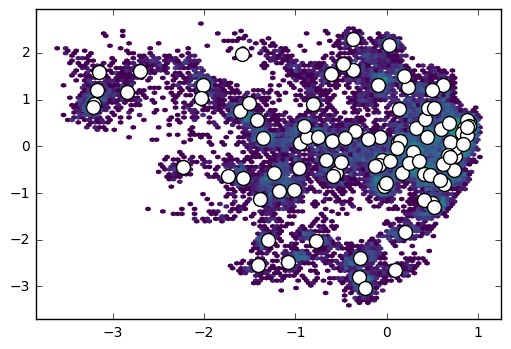

In [8]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [9]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20, ergodic_cutoff='on')
msm.fit(clustered_trajs)

MSM contains 3 strongly connected components above weight=0.50. Component 1 selected, with population 95.433725%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

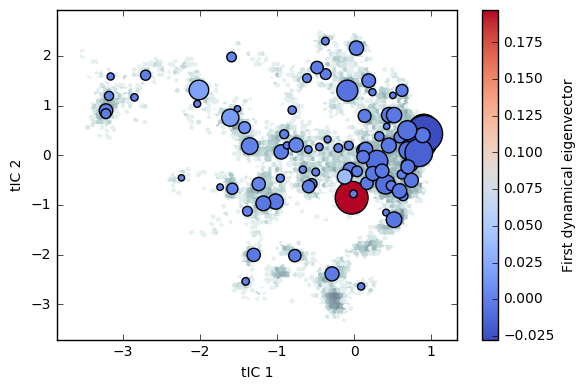

In [10]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [12]:
# Generating trajectory from MSM
# Make sure to do stride = 1 to get the most diverse frames

import random
import mdtraj as md

num_frames = 100000


sample = msm.draw_samples(clustered_trajs, n_samples= 300) #State, Trajectory ID, Frame

starting_idx = {}
for i in range(len(xyz)):
    if i == 0:
        starting_idx[i] = 0
    else:
        starting_idx[i] = starting_idx[i-1] + len(xyz[i])

traj_raw = msm.sample(msm.transmat_, num_frames) #Raw trajectory with only state labels
traj = []
for state in traj_raw:
    traj_id, frame = next_frame = random.choice(sample[msm.mapping_[state]]) #Pick a random frame
    traj.append(starting_idx[traj_id] + frame)
    
our_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))
md_traj = md.Trajectory(our_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)
location = 'C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\\'

md_traj.save_xtc(location + 'long.xtc') # Saves an xtc trajectory file
np.save('long.dat', X[traj,:]) # Saves a .dat file

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [13]:
# More efficient but I sample from all the frames
num_frames = 100000


cluster_label = np.array([])
for array in clustered_trajs:
    if cluster_label.shape[0] == 0:
        cluster_label = array
    else:
        cluster_label = np.concatenate((cluster_label, array))

traj_raw = msm.sample(msm.transmat_, num_frames) #Raw trajectory with only state labels
traj = []
for state in traj_raw:
    options = np.where(cluster_label == state)[0]
    next_frame = np.random.choice(options)
    traj.append(next_frame)
    
our_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))
md_traj = md.Trajectory(our_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)
location = 'C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\\'

md_traj.save_xtc(location + 'long.xtc') # Saves an xtc trajectory file
np.save('long.dat', X[traj,:]) # Saves a .dat file

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
